In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from matplotlib import animation 
    
from datetime import datetime
import time

In [2]:
class Evol:
    def __init__(self, xi, t, k0, gamma):
        # xi should be uniform!
        self.xi = xi
        self.t = t
        self.k0 = k0
        self.gamma = gamma
        delta_xi = xi[1] - xi[0]
        diagLaplacian_xi = -2/delta_xi**2 * np.ones(len(self.xi[1:-1]))
        subdiagLaplacian_xi = 1/delta_xi**2 * np.ones(len(self.xi[1:-1])-1)
        diagsLaplacian_xi = [subdiagLaplacian_xi,
                             diagLaplacian_xi,
                             subdiagLaplacian_xi]
        self.Laplacian_xi = scipy.sparse.diags(diagsLaplacian_xi,[-1,0,1]).toarray()  
    
    def R(self, tt):
#         return 1+self.gamma*tt
        return np.sqrt(1+self.gamma*tt**2)
    
    def R1(self, tt):
#         return self.gamma
        return self.gamma * tt / np.sqrt(1+self.gamma*tt**2)
    
    def R2(self, tt):
#         return 0.0
        return self.gamma / np.sqrt(1+self.gamma*tt**2) \
               - (self.gamma * tt)**2 / (1+self.gamma*tt**2)**(3/2)
    
    def x(self, tt):
        return self.R(tt) * self.xi
    
    def analiticalPsi(self):
        r = []
        for tt in self.t:
            x = self.x(tt)[1:-1]
            r += [np.exp((2*self.k0+1j*x)**2/(4*(1+1j*tt)) - self.k0**2)\
                  / (2*np.pi)**(1/4) / np.sqrt(1+1j*tt)]
        return r
    
    def numericalPsi(self):
        psi = [np.exp((2*self.k0+1j*self.x(0)[1:-1])**2/(4) - self.k0**2)\
               / (2*np.pi)**(1/4)]
        phi = [np.sqrt(self.R(0)) \
               * np.exp(-1j/4*self.R(0)*self.R1(0)*self.xi[1:-1]**2) \
               * psi[0]]
        for i in range(len(self.t)-1):
            tt = (self.t[i+1] + self.t[i]) / 2
            H_xi = -self.R(tt)**(-2) * self.Laplacian_xi \
                   + 0.25*self.R2(tt)*self.R(tt)*self.xi[1:-1]**2*np.eye(len(self.xi[1:-1]))
            U = scipy.linalg.expm(-1j*H_xi*(self.t[i+1]-self.t[i]))
            phi += [U @ phi[-1]]
            psi += [self.R(self.t[i+1])**(-1/2)\
                    *np.exp(1j/4*self.R(self.t[i+1])*self.R1(self.t[i+1])*self.xi[1:-1]**2)*phi[-1]]
        return psi

In [3]:
nIter = 100
obj = Evol(np.linspace(-10,10,202), np.linspace(0,10,nIter), 0.5, 1)
psiIt = obj.numericalPsi()
psiAn = obj.analiticalPsi()

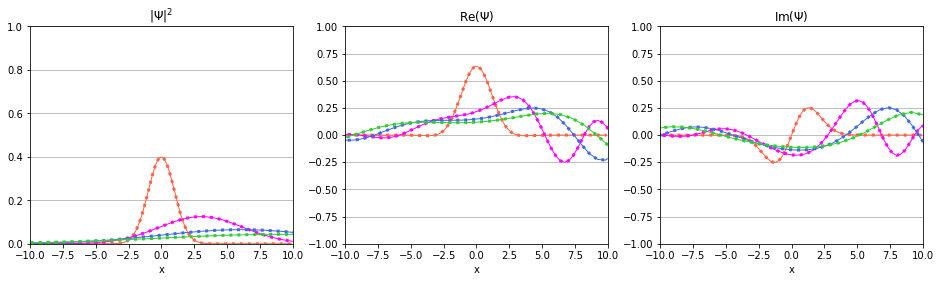

In [6]:
fig, (ax, axR, axI) = plt.subplots(1,3, figsize=(16,4))

ax.set(xlim=(-10, 10), ylim=(0, 1), title=r'$|\Psi|^2$')
ax.grid(axis='y')
ax.set_xlabel('x')
# real \Psi
axR.set(xlim=(-10, 10), ylim=(-1, 1), title=r'$\mathrm{Re}(\Psi)$')
axR.grid(axis='y')
axR.set_xlabel('x')
# imegine \Psi
axI.set(xlim=(-10, 10), ylim=(-1, 1), title=r'$\mathrm{Im}(\Psi)$')
axI.grid(axis='y')
axI.set_xlabel('x')

cs=['tomato', 'magenta', 'royalblue', 'limegreen']

for i in [0, 30, 60, 90]:
    ax.plot(obj.x(obj.t[i])[1:-1], np.absolute(psiAn[i])**2, lw=1, linestyle='-', c=cs[i//30])
    ax.plot(obj.x(obj.t[i])[1:-1], np.absolute(psiIt[i])**2, lw=3, linestyle=':', c=cs[i//30])
    axR.plot(obj.x(obj.t[i])[1:-1], np.real(psiAn[i]), lw=1, linestyle='-', c=cs[i//30])
    axR.plot(obj.x(obj.t[i])[1:-1], np.real(psiIt[i]), lw=3, linestyle=':', c=cs[i//30])
    axI.plot(obj.x(obj.t[i])[1:-1], np.imag(psiAn[i]), lw=1, linestyle='-', c=cs[i//30])
    axI.plot(obj.x(obj.t[i])[1:-1], np.imag(psiIt[i]), lw=3, linestyle=':', c=cs[i//30])

fig.savefig('figures/comparison.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


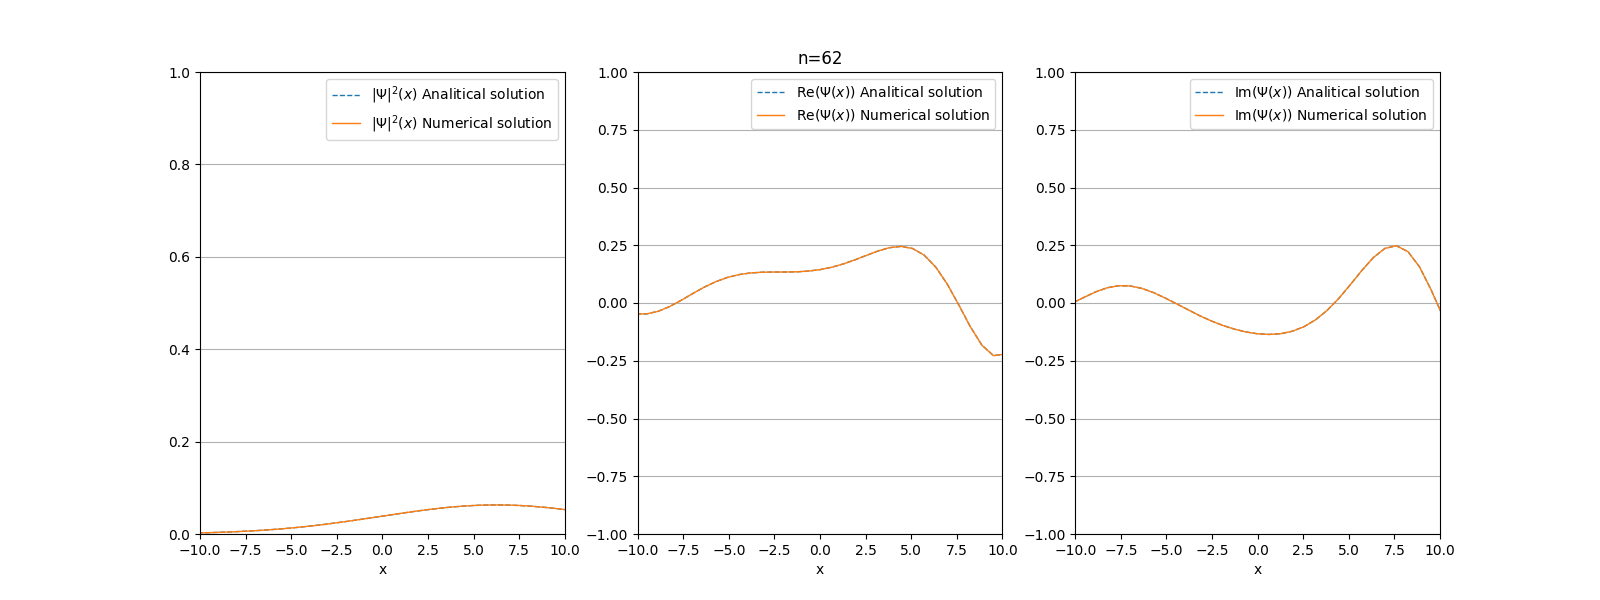

In [4]:
%matplotlib notebook 

# First set up the figure, the axis, and the plot element we want to animate
fig, (ax, axR, axI) = plt.subplots(1,3, figsize=(16,6))
# |\Psi|**2
ax.set(xlim=(-10, 10), ylim=(0, 1))
line1, = ax.plot([], [], lw=1, linestyle='--', label='$|\Psi|^2(x)$ Analitical solution')
# line2, = ax.plot([], [], lw=1, marker='.', label=r'$|\Psi|^2(x)$ Runge-Kutta 4th range')
line3, = ax.plot([], [], lw=1, label=r'$|\Psi|^2(x)$ Numerical solution')
# lineMask, = ax.plot(ev.x[1:-1], ev.mask, lw=1, c='red', label='Mask', clip_on=False)
ax.legend()
ax.grid(axis='y')
ax.set_xlabel('x')
# real \Psi
axR.set(xlim=(-10, 10), ylim=(-1, 1))
line4, = axR.plot([], [], lw=1, linestyle='--', label='$\mathrm{Re}(\Psi(x))$ Analitical solution')
line5, = axR.plot([], [], lw=1, label=r'$\mathrm{Re}(\Psi(x))$ Numerical solution')
axR.legend()
axR.grid(axis='y')
axR.set_xlabel('x')
# imegine \Psi
axI.set(xlim=(-10, 10), ylim=(-1, 1))
line6, = axI.plot([], [], lw=1, linestyle='--', label='$\mathrm{Im}(\Psi(x))$ Analitical solution')
line7, = axI.plot([], [], lw=1, label=r'$\mathrm{Im}(\Psi(x))$ Numerical solution')
axI.legend()
axI.grid(axis='y')
axI.set_xlabel('x')

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
#     line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line7.set_data([], [])
    return line1, line3, line4, line5, line6, line7#, line3,

# animation function.  This is called sequentially
def animate(i):
    line1.set_data(obj.x(obj.t[i])[1:-1], np.absolute(psiAn[i])**2)
#     line2.set_data(ev.x[1:-1], np.absolute(psiRK[i])**2)
    line3.set_data(obj.x(obj.t[i])[1:-1], np.absolute(psiIt[i])**2)
    line4.set_data(obj.x(obj.t[i])[1:-1], np.real(psiAn[i]))
    line5.set_data(obj.x(obj.t[i])[1:-1], np.real(psiIt[i]))
    line6.set_data(obj.x(obj.t[i])[1:-1], np.imag(psiAn[i]))
    line7.set_data(obj.x(obj.t[i])[1:-1], np.imag(psiIt[i]))
    axR.set_title(fr'n={i}')
    return line1, line3, line4, line5, line6, line7 #line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nIter, blit=True)

# # save the animation as an mp4.  This requires ffmpeg or mencoder to be
# # installed.  The extra_args ensure that the x264 codec is used, so that
# # the video can be embedded in html5.  You may need to adjust this for
# # your system: for more information, see
# # http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('figures/basic_animation.mp4', writer=animation.FFMpegWriter(fps=5), dpi=250)

plt.show()  